pdf: [link](https://drive.google.com/file/d/1tHXKpTUyyuxfbXdFk6oh9mEE7xr4GwOP/view?usp=sharing)

video: [link](https://drive.google.com/file/d/1pU1E8g2VOe7LzrK0z1hCwo89yeYGrZir/view?usp=sharing)

colab: [link](https://colab.research.google.com/drive/1NL9lPIutvIVeiya6GksEQqEoa2w4-JAZ?usp=sharing)

paper: [link](https://arxiv.org/pdf/1706.03762v5.pdf)

Pytorch-implementation: [link](https://github.com/ArashLagzian/attention-is-all-you-need-pytorch)

TensorFelow-implementation: [link](https://github.com/tensorflow/models/tree/master/official/nlp/transformer)

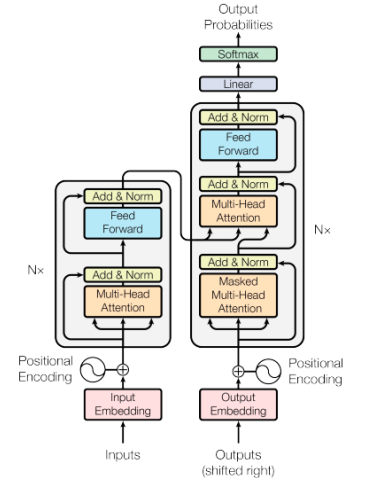

# Constatnt

In [ ]:
PAD_WORD = '<blank>'
UNK_WORD = '<unk>'
BOS_WORD = '<s>'
EOS_WORD = '</s>'

# Madules

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class ScaledDotProductAttention(nn.Module):
    ''' Scaled Dot-Product Attention '''
    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)
    def forward(self, q, k, v, mask=None):
        attn = torch.matmul(q / self.temperature, k.transpose(2, 3))
        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)
        attn = self.dropout(F.softmax(attn, dim=-1))
        output = torch.matmul(attn, v)
        return output, 

# sublayers

In [ ]:
''' Define the sublayers in encoder/decoder layer '''
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from Modules import ScaledDotProductAttention

class MultiHeadAttention(nn.Module):
    ''' Multi-Head Attention module '''
    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.w_qs = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_ks = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_vs = nn.Linear(d_model, n_head * d_v, bias=False)
        self.fc = nn.Linear(n_head * d_v, d_model, bias=False)
        self.attention = ScaledDotProductAttention(temperature=d_k ** 0.5)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
    def forward(self, q, k, v, mask=None):
        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        sz_b, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1)
        residual = q
        # Pass through the pre-attention projection: b x lq x (n*dv)
        # Separate different heads: b x lq x n x dv
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)
        # Transpose for attention dot product: b x n x lq x dv
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)
        if mask is not None:
            mask = mask.unsqueeze(1)   # For head axis broadcasting.
        q, attn = self.attention(q, k, v, mask=mask)
        # Transpose to move the head dimension back: b x lq x n x dv
        # Combine the last two dimensions to concatenate all the heads together: b x lq x (n*dv)
        q = q.transpose(1, 2).contiguous().view(sz_b, len_q, -1)
        q = self.dropout(self.fc(q))
        q += residual
        q = self.layer_norm(q)
        return q, attn


class PositionwiseFeedForward(nn.Module):
    ''' A two-feed-forward-layer module '''
    def __init__(self, d_in, d_hid, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_in, d_hid) # position-wise
        self.w_2 = nn.Linear(d_hid, d_in) # position-wise
        self.layer_norm = nn.LayerNorm(d_in, eps=1e-6)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        residual = x
        x = self.w_2(F.relu(self.w_1(x)))
        x = self.dropout(x)
        x += residual
        x = self.layer_norm(x)
        return x

# Layers

In [ ]:
import torch.nn as nn
import torch
from SubLayers import MultiHeadAttention, PositionwiseFeedForward
class EncoderLayer(nn.Module):
    ''' Compose with two layers '''
    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)
    def forward(self, enc_input, slf_attn_mask=None):
        enc_output, enc_slf_attn = self.slf_attn(
            enc_input, enc_input, enc_input, mask=slf_attn_mask)
        enc_output = self.pos_ffn(enc_output)
        return enc_output, enc_slf_attn
class DecoderLayer(nn.Module):
    ''' Compose with three layers '''
    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.enc_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)
    def forward(
            self, dec_input, enc_output,
            slf_attn_mask=None, dec_enc_attn_mask=None):
        dec_output, dec_slf_attn = self.slf_attn(
            dec_input, dec_input, dec_input, mask=slf_attn_mask)
        dec_output, dec_enc_attn = self.enc_attn(
            dec_output, enc_output, enc_output, mask=dec_enc_attn_mask)
        dec_output = self.pos_ffn(dec_output)
        return dec_output, dec_slf_attn, dec_enc_attn

# Models

In [ ]:
''' Define the Transformer model '''
import torch
import torch.nn as nn
import numpy as np
from Layers import EncoderLayer, DecoderLayer
def get_pad_mask(seq, pad_idx):
    return (seq != pad_idx).unsqueeze(-2)
def get_subsequent_mask(seq):
    ''' For masking out the subsequent info. '''
    sz_b, len_s = seq.size()
    subsequent_mask = (1 - torch.triu(
        torch.ones((1, len_s, len_s), device=seq.device), diagonal=1)).bool()
    return subsequent_mask


class PositionalEncoding(nn.Module):
    def __init__(self, d_hid, n_position=200):
        super(PositionalEncoding, self).__init__()
        # Not a parameter
        self.register_buffer('pos_table', self._get_sinusoid_encoding_table(n_position, d_hid))
    def _get_sinusoid_encoding_table(self, n_position, d_hid):
        ''' Sinusoid position encoding table '''
        # TODO: make it with torch instead of numpy
        def get_position_angle_vec(position):
            return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)]
        sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)])
        sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
        sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1
        return torch.FloatTensor(sinusoid_table).unsqueeze(0)
    def forward(self, x):
        return x + self.pos_table[:, :x.size(1)].clone().detach()


class Encoder(nn.Module):
    ''' A encoder model with self attention mechanism. '''
    def __init__(
            self, n_src_vocab, d_word_vec, n_layers, n_head, d_k, d_v,
            d_model, d_inner, pad_idx, dropout=0.1, n_position=200, scale_emb=False):
        super().__init__()
        self.src_word_emb = nn.Embedding(n_src_vocab, d_word_vec, padding_idx=pad_idx)
        self.position_enc = PositionalEncoding(d_word_vec, n_position=n_position)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_stack = nn.ModuleList([
            EncoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.scale_emb = scale_emb
        self.d_model = d_model
    def forward(self, src_seq, src_mask, return_attns=False):
        enc_slf_attn_list = []
        # -- Forward
        enc_output = self.src_word_emb(src_seq)
        if self.scale_emb:
            enc_output *= self.d_model ** 0.5
        enc_output = self.dropout(self.position_enc(enc_output))
        enc_output = self.layer_norm(enc_output)
        for enc_layer in self.layer_stack:
            enc_output, enc_slf_attn = enc_layer(enc_output, slf_attn_mask=src_mask)
            enc_slf_attn_list += [enc_slf_attn] if return_attns else []
        if return_attns:
            return enc_output, enc_slf_attn_list
        return enc_output,


class Decoder(nn.Module):
    ''' A decoder model with self attention mechanism. '''
    def __init__(
            self, n_trg_vocab, d_word_vec, n_layers, n_head, d_k, d_v,
            d_model, d_inner, pad_idx, n_position=200, dropout=0.1, scale_emb=False):
        super().__init__()
        self.trg_word_emb = nn.Embedding(n_trg_vocab, d_word_vec, padding_idx=pad_idx)
        self.position_enc = PositionalEncoding(d_word_vec, n_position=n_position)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_stack = nn.ModuleList([
            DecoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.scale_emb = scale_emb
        self.d_model = d_model
    def forward(self, trg_seq, trg_mask, enc_output, src_mask, return_attns=False):
        dec_slf_attn_list, dec_enc_attn_list = [], []
        # -- Forward
        dec_output = self.trg_word_emb(trg_seq)
        if self.scale_emb:
            dec_output *= self.d_model ** 0.5
        dec_output = self.dropout(self.position_enc(dec_output))
        dec_output = self.layer_norm(dec_output)
        for dec_layer in self.layer_stack:
            dec_output, dec_slf_attn, dec_enc_attn = dec_layer(
                dec_output, enc_output, slf_attn_mask=trg_mask, dec_enc_attn_mask=src_mask)
            dec_slf_attn_list += [dec_slf_attn] if return_attns else []
            dec_enc_attn_list += [dec_enc_attn] if return_attns else []
        if return_attns:
            return dec_output, dec_slf_attn_list, dec_enc_attn_list
        return dec_output,


class Transformer(nn.Module):
    ''' A sequence to sequence model with attention mechanism. '''
    def __init__(
            self, n_src_vocab, n_trg_vocab, src_pad_idx, trg_pad_idx,
            d_word_vec=512, d_model=512, d_inner=2048,
            n_layers=6, n_head=8, d_k=64, d_v=64, dropout=0.1, n_position=200,
            trg_emb_prj_weight_sharing=True, emb_src_trg_weight_sharing=True,
            scale_emb_or_prj='prj'):
        super().__init__()
        self.src_pad_idx, self.trg_pad_idx = src_pad_idx, trg_pad_idx
        # In section 3.4 of paper "Attention Is All You Need", there is such detail:
        # "In our model, we share the same weight matrix between the two
        # embedding layers and the pre-softmax linear transformation...
        # In the embedding layers, we multiply those weights by \sqrt{d_model}".
        # Options here:
        #   'emb': multiply \sqrt{d_model} to embedding output
        #   'prj': multiply (\sqrt{d_model} ^ -1) to linear projection output
        #   'none': no multiplication
        assert scale_emb_or_prj in ['emb', 'prj', 'none']
        scale_emb = (scale_emb_or_prj == 'emb') if trg_emb_prj_weight_sharing else False
        self.scale_prj = (scale_emb_or_prj == 'prj') if trg_emb_prj_weight_sharing else False
        self.d_model = d_model
        self.encoder = Encoder(
            n_src_vocab=n_src_vocab, n_position=n_position,
            d_word_vec=d_word_vec, d_model=d_model, d_inner=d_inner,
            n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v,
            pad_idx=src_pad_idx, dropout=dropout, scale_emb=scale_emb)
        self.decoder = Decoder(
            n_trg_vocab=n_trg_vocab, n_position=n_position,
            d_word_vec=d_word_vec, d_model=d_model, d_inner=d_inner,
            n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v,
            pad_idx=trg_pad_idx, dropout=dropout, scale_emb=scale_emb)
        self.trg_word_prj = nn.Linear(d_model, n_trg_vocab, bias=False)
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p) 
        assert d_model == d_word_vec, \
        'To facilitate the residual connections, \
         the dimensions of all module outputs shall be the same.'
        if trg_emb_prj_weight_sharing:
            # Share the weight between target word embedding & last dense layer
            self.trg_word_prj.weight = self.decoder.trg_word_emb.weight
        if emb_src_trg_weight_sharing:
            self.encoder.src_word_emb.weight = self.decoder.trg_word_emb.weight
    def forward(self, src_seq, trg_seq):
        src_mask = get_pad_mask(src_seq, self.src_pad_idx)
        trg_mask = get_pad_mask(trg_seq, self.trg_pad_idx) & get_subsequent_mask(trg_seq)
        enc_output, *_ = self.encoder(src_seq, src_mask)
        dec_output, *_ = self.decoder(trg_seq, trg_mask, enc_output, src_mask)
        seq_logit = self.trg_word_prj(dec_output)
        if self.scale_prj:
            seq_logit *= self.d_model ** -0.5
        return seq_logit.view(-1, seq_logit.size(2))

# Optim

In [ ]:
'''A wrapper class for scheduled optimizer '''
import numpy as np
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''
    def __init__(self, optimizer, lr_mul, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.lr_mul = lr_mul
        self.d_model = d_model
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = 0
    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()
    def zero_grad(self):
        "Zero out the gradients with the inner optimizer"
        self._optimizer.zero_grad()
    def _get_lr_scale(self):
        d_model = self.d_model
        n_steps, n_warmup_steps = self.n_steps, self.n_warmup_steps
        return (d_model ** -0.5) * min(n_steps ** (-0.5), n_steps * n_warmup_steps ** (-1.5))
    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''
        self.n_steps += 1
        lr = self.lr_mul * self._get_lr_scale()
        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr